# AI를 활용한 포트폴리오 최적화 모델 구현

포트폴리오 최적화(Portfolio Optimization)는 주요한 계량적 투자방법 중 하나입니다. 대표적인 포트폴리오 최적화 방법으로는 과거 수익율의 평균과 분산을 활용하여 원하는 자산별 투자비율을 설정을 통해 위험대비 수익율을 최대화 하는 방법이 대표적입니다. 이외에도 과거의 정보만을 가지고 판단하는 방법의 단점을 개선하여 미래에 대한 전망을 반영하여 포트폴리오를 최적화하는 블랙리터만(Black-Litterman) 방법이 있습니다.

최근들어서는 딥러닝과 같은 인공지능 기술을 활용하는 방법이 많이 연구되고 있습니다. 여기서는 전통적인 마코비츠(Markowitz) 방법과 딥러닝을 접목하여 포트폴리오를 최적화 하는 모델을 구현하겠습니다.

## 필요 라이브러리 임포트

In [8]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
import tensorflow_probability as tfp

# tensorflow의 래핑 라이브러리인 keras에서 본 튜토리얼에 사용할 기능들
from keras.models import Sequential, Model, load_model
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.models import Input
# from tensorflow.keras.optimizers import Adam

plt.style.use('seaborn-whitegrid')
plt.rc('font', family="Malgun Gothic")
plt.rc('axes', unicode_minus=False)

In [9]:
# 로그수익율로 전처리 완료된 파일을 불러온다.
dr = pd.read_csv('data_preprocessed.csv', index_col=0, parse_dates=True)
# dr = pd.read_csv('https://github.com/suhan-jung/portfolio_optimization/blob/master/data/data_preprocessed.csv', index_col=0, parse_dates=True)
print(dr.index)

DatetimeIndex(['2011-01-31', '2011-02-01', '2011-02-02', '2011-02-03',
               '2011-02-04', '2011-02-07', '2011-02-08', '2011-02-09',
               '2011-02-10', '2011-02-11',
               ...
               '2022-04-27', '2022-04-28', '2022-04-29', '2022-05-02',
               '2022-05-03', '2022-05-04', '2022-05-05', '2022-05-06',
               '2022-05-09', '2022-05-10'],
              dtype='datetime64[ns]', name='Date', length=2839, freq=None)


In [10]:
tickers = dr.columns.values
tickers

array(['DBE US Equity', 'IAU US Equity', 'SLV US Equity', 'AIA US Equity',
       'VPL US Equity', 'VGK US Equity', 'VWO US Equity',
       'VXUS US Equity', 'RWO US Equity', 'VOO US Equity', 'VO US Equity',
       'VB US Equity', 'SCHH US Equity', 'EMLC US Equity',
       'AGG US Equity'], dtype=object)

## Train / Test data 분리 - 8 : 2

In [11]:
# train data : test data = 80 : 20
train_index = int(dr.shape[0]*0.8)
print(train_index)
# 80:20 으로 train / test 분할 (numpy array로 변환)
train_data = dr[:train_index].values
train_date = dr[:train_index].index.values.astype('datetime64[D]')
print("train data index")
print(dr[:train_index].index)
test_data = dr[train_index:].values
test_date = dr[train_index:].index.values.astype('datetime64[D]')
print("test data index")
print(dr[train_index:].index)


2271
train data index
DatetimeIndex(['2011-01-31', '2011-02-01', '2011-02-02', '2011-02-03',
               '2011-02-04', '2011-02-07', '2011-02-08', '2011-02-09',
               '2011-02-10', '2011-02-11',
               ...
               '2020-01-27', '2020-01-28', '2020-01-29', '2020-01-30',
               '2020-01-31', '2020-02-03', '2020-02-04', '2020-02-05',
               '2020-02-06', '2020-02-07'],
              dtype='datetime64[ns]', name='Date', length=2271, freq=None)
test data index
DatetimeIndex(['2020-02-10', '2020-02-11', '2020-02-12', '2020-02-13',
               '2020-02-14', '2020-02-18', '2020-02-19', '2020-02-20',
               '2020-02-21', '2020-02-24',
               ...
               '2022-04-27', '2022-04-28', '2022-04-29', '2022-05-02',
               '2022-05-03', '2022-05-04', '2022-05-05', '2022-05-06',
               '2022-05-09', '2022-05-10'],
              dtype='datetime64[ns]', name='Date', length=568, freq=None)


In [12]:
train_date

array(['2011-01-31', '2011-02-01', '2011-02-02', ..., '2020-02-05',
       '2020-02-06', '2020-02-07'], dtype='datetime64[D]')

### Data 준비 - sliding window

In [13]:
def make_data_window(data, window_size_past, window_size_future):
    # sequential data와 과거데이터 수, 미래 데이터 수 를 받아서 과거데이터 ndarray, 미래데이터 ndarray를 반환한다.
    inputs_past = []
    inputs_future = []
    # print(len(data)-window_size_past-window_size_future)
    for i in range(len(data)-window_size_past-window_size_future):
        # print(i)
        inputs_past.append(data[i:i+window_size_past].copy())
        inputs_future.append(data[i+window_size_past:i+window_size_past+window_size_future].copy())
        
    np_inputs_past = np.array(inputs_past)
    np_inputs_future = np.array(inputs_future)
    return np_inputs_past, np_inputs_future

In [14]:
# 자산배분비율 산출 기준 : 과거 60일 데이터로 산출, 미래 20일의 최적수익율로 최적화
window_size_past = 60
window_size_future = 20

xc_train, xf_train = make_data_window(train_data, window_size_past, window_size_future)
xc_test, xf_test = make_data_window(test_data, window_size_past, window_size_future)


In [15]:
xc_train_date = train_date[:len(train_date)-window_size_past-window_size_future]
xc_train_date

array(['2011-01-31', '2011-02-01', '2011-02-02', ..., '2019-10-10',
       '2019-10-11', '2019-10-14'], dtype='datetime64[D]')

In [16]:
print("xc_train.shape:",xc_train.shape)
print("xf_train.shape:",xf_train.shape)
print("xc_test.shape:",xc_test.shape)
print("xf_test.shape:",xf_test.shape)

xc_train.shape: (2191, 60, 15)
xf_train.shape: (2191, 20, 15)
xc_test.shape: (488, 60, 15)
xf_test.shape: (488, 20, 15)


## MPN(Markowitz Portfolio Network) 만들기

### 주요 상수 설정

In [17]:
# 월간 수익율 정도의 스케일로 변환한다.(아마퀀트님 코드)
# scikit-learn 의 scaler 를 사용하는게 낫지 않을까?
xc_train_scaled = xc_train.astype('float32') * 20.0
xf_train_scaled = xf_train.astype('float32') * 20.0
xc_test_scaled = xc_test.astype('float32') * 20.0
xf_test_scaled = xf_test.astype('float32') * 20.0

N_TIME = xc_train_scaled.shape[1]
N_FUTURE = xf_train_scaled.shape[1]
N_STOCKS = xf_train_scaled.shape[2]

# 입력 순서에 따른 상관성을 제거하기 위해 sklearn.utils의 함수를 이용해서 shuffle을 수행한다.
xc_train_scaled, xf_train_scaled = shuffle(xc_train_scaled, xf_train_scaled)

# over confidence를 제어할 조절 변수 정의
GAMMA_CONST = 0.1
# GAMMA_CONST = 0.001
REG_CONST = 0.1
# REG_CONST = 0.001
SAVE_MODEL = 'mpn.h5'

In [18]:
N_TIME, N_FUTURE

(60, 20)

### 목적함수 정의

In [19]:
def markowitz_objective(y_true, y_pred):
    W = y_pred
    xf_rtn = y_true
    W = tf.expand_dims(W, axis=1)
    R = tf.expand_dims(tf.reduce_mean(xf_rtn, axis=1), axis=2)
    C = tfp.stats.covariance(xf_rtn, sample_axis=1)
    
    rtn = tf.matmul(W, R)
    vol = tf.matmul(W, tf.matmul(C, tf.transpose(W, perm=[0,2,1]))) * GAMMA_CONST
    reg = tf.reduce_sum(tf.square(W), axis=-1) * REG_CONST
    # print(f"rtn: {rtn}, vol: {vol}, reg: {reg}")
    objective = rtn - vol - reg
    
    return -tf.reduce_mean(objective, axis=0)

### LSTM 모델 생성

In [20]:
# LSTM으로 Markowitz 모델을 생성한다.
xc_input = Input(batch_shape=(None, N_TIME, N_STOCKS))
h_lstm = LSTM(64, dropout=0.5)(xc_input)
y_output = Dense(N_STOCKS, activation='tanh')(h_lstm)

# 특정 종목을 과도하게 매수하는 것을 방지하기 위해 위에서 tanh를 사용했다.(over confidence 방지용)
# REG_CONST를 적용했기때문에 이미 고려된 사항이지만, 안전을 위해 추가했다.

# 마코비츠의 최적 weights
y_output = Activation('softmax')(y_output)

model = Model(inputs=xc_input, outputs=y_output)
model.compile(loss=markowitz_objective, optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2, decay=0.001))

### 모델 학습

In [21]:
# MPN을 학습하고 결과를 저장한다.
hist = model.fit(xc_train_scaled, xf_train_scaled, epochs=100, batch_size=32, validation_data=(xc_test_scaled, xf_test_scaled))
model.save(SAVE_MODEL)

Epoch 1/100
69/69 [==============================] - 3s 22ms/step - loss: 0.0053 - val_loss: -0.0026
Epoch 2/100
69/69 [==============================] - 1s 17ms/step - loss: 0.0050 - val_loss: -0.0024
Epoch 3/100
69/69 [==============================] - 1s 16ms/step - loss: 0.0047 - val_loss: -0.0023
Epoch 4/100
69/69 [==============================] - 1s 16ms/step - loss: 0.0041 - val_loss: -1.7494e-04
Epoch 5/100
69/69 [==============================] - 1s 16ms/step - loss: 0.0037 - val_loss: -0.0023
Epoch 6/100
69/69 [==============================] - 1s 16ms/step - loss: 0.0024 - val_loss: -0.0026
Epoch 7/100
69/69 [==============================] - 1s 17ms/step - loss: 8.8063e-04 - val_loss: -0.0016
Epoch 8/100
69/69 [==============================] - 1s 16ms/step - loss: 3.3520e-06 - val_loss: 4.7939e-04
Epoch 9/100
69/69 [==============================] - 1s 17ms/step - loss: -9.7098e-04 - val_loss: -8.3204e-04
Epoch 10/100
69/69 [==============================] - 1s 16ms/step 

### 학습결과 확인(loss)

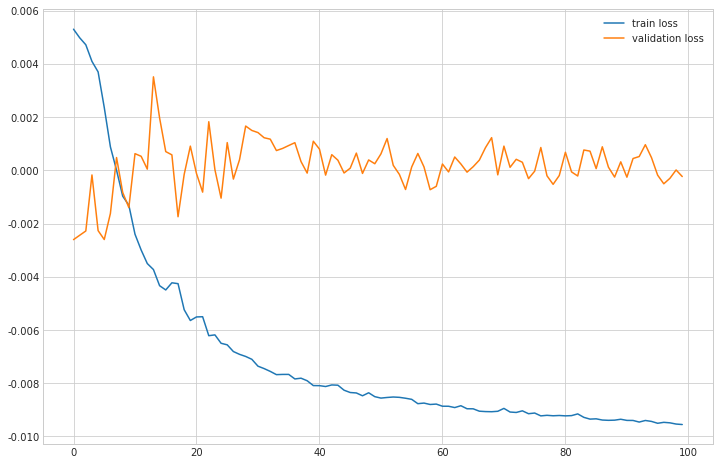

In [22]:
# loss trajectory를 확인한다.
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

### 최적 투자비율 추정

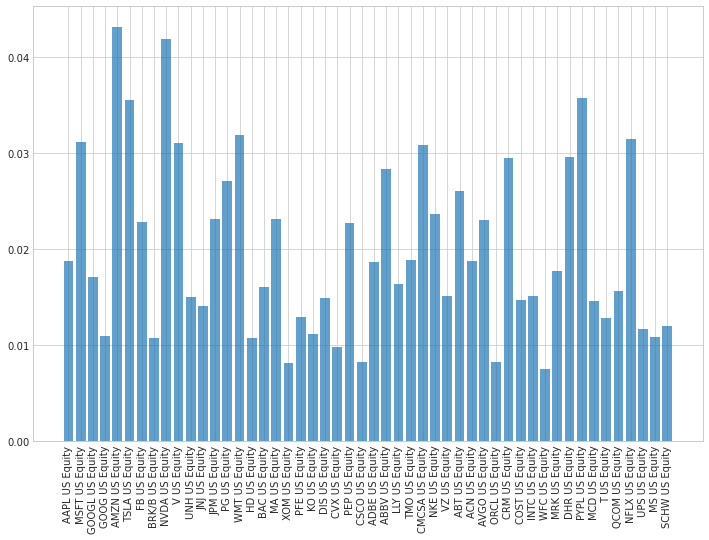

In [17]:
def check_w(n=0):
    plt.figure(figsize=(12,8))
    y_pred = model.predict(xc_test[n].reshape(1, N_TIME, N_STOCKS))[0]
    # plt.bar(np.arange(N_STOCKS), y_pred, alpha=0.7)
    plt.bar(tickers, y_pred, alpha=0.7)
    plt.xticks(rotation=90)
    plt.show()

check_w(0)

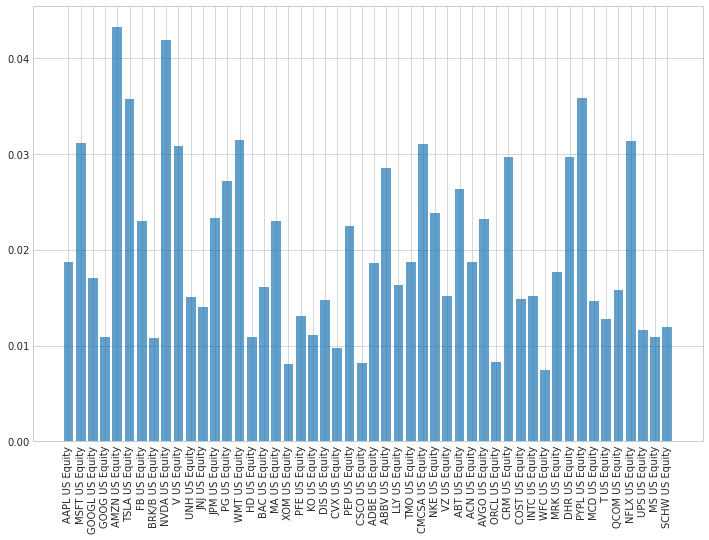

In [19]:
check_w(20)

## 성능 평가

In [20]:
# 저장된 Markowitz 모델을 가져온다.
SAVE_MODEL = 'mpn.h5'
model = load_model(SAVE_MODEL, compile = False)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 50)]          0         
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 dense (Dense)               (None, 50)                3250      
                                                                 
 activation (Activation)     (None, 50)                0         
                                                                 
Total params: 32,690
Trainable params: 32,690
Non-trainable params: 0
_________________________________________________________________


## Backtesting

In [22]:
# 백 테스트를 수행한다.
prt_value = [10000]   # portfolio의 초기 value
crp_value = [10000]   # CRP의 초기 value
spy_value = [10000]
w_crp = np.ones(N_STOCKS) / N_STOCKS   # CRP 비율 (균등 비율)
w_spy = np.zeros(N_STOCKS)
w_spy[9] = 1

w_history = []
date_history = [test_date[0]] # 시작일을 저장한다.

for i in range(0, xc_test_scaled.shape[0], N_FUTURE):
    # 이 시점에 각 종목을 w_prt 비율대로 매수한다.
    # 학습할 때 월간 수익률로 변환했으므로, 여기서도 변환해야 한다.
    # x = xc_test[i][np.newaxis,:,:] * 20.0
    x = xc_test_scaled[i][np.newaxis,:,:]
    w_prt = model.predict(x)[0]
    w_history.append(w_prt)
    date_history.append(test_date[i+N_TIME])

    # 다음 기의 누적 수익률
    m_rtn = np.sum(xf_test[i], axis = 0)

    # 누적 수익률과 w_prt (W)로 포트폴리오의 수익률을 계산한다.
    prt_value.append(prt_value[-1] * np.exp(np.dot(w_prt, m_rtn)))
    # print(f"m_rtn: {m_rtn}")
    # print(f"w_prt: {w_prt}")
    crp_value.append(crp_value[-1] * np.exp(np.dot(w_crp, m_rtn)))
    spy_value.append(crp_value[-1] * np.exp(np.dot(w_spy, m_rtn)))


In [23]:
np_w_history = np.array(w_history)


<AxesSubplot:>

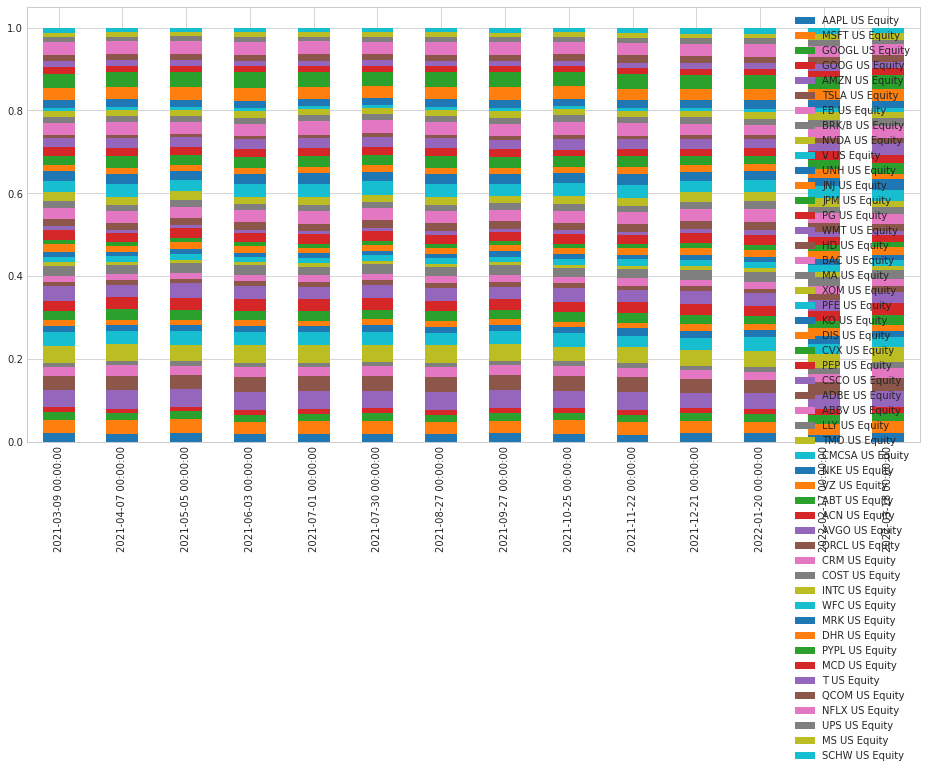

In [24]:
pd.DataFrame(data=np_w_history, index=date_history[1:], columns=tickers).plot(figsize=(16,8), stacked=True, kind='bar')

In [25]:
prt_value

[10000,
 10712.959819734244,
 10900.028934072123,
 10978.845781597263,
 11479.382074835188,
 11823.573080925453,
 12036.245125198982,
 12048.677238766444,
 12273.343287900336,
 12724.053291963146,
 12358.480210463811,
 12162.993380229258,
 11718.301443312524,
 11552.714810901673,
 11380.152426108565]

In [26]:
crp_value

[10000,
 10630.647329661,
 10890.51673559182,
 10984.244783147942,
 11329.015799619669,
 11670.707495353137,
 11876.469445311128,
 11855.138962239345,
 12124.461014429064,
 12473.25251412271,
 12298.431810882526,
 12216.907865997742,
 11891.562525624697,
 11745.728973792977,
 11597.47402942503]

In [27]:
spy_value

[10000,
 10552.46266587915,
 11556.950653617563,
 10887.838274914026,
 11534.226326139957,
 12374.481553630016,
 11057.983992361625,
 11910.167466863157,
 12105.613044400434,
 10854.071011042284,
 12780.915176492581,
 12564.560470392691,
 12695.420909458171,
 10956.760114745703,
 11561.613955124636]

In [28]:

# 평가 시점의 날짜를 발췌한다.
# idx = np.arange(0, len(test_date), N_FUTURE)

# Markowitz 성과와 CRP 성과를 데이터 프레임에 기록해 둔다.
# perf_df = pd.DataFrame({'crp':crp_value, 'markowitz':prt_value}, index=test_date[idx])
perf_df = pd.DataFrame({'crp':crp_value, 'markowitz':prt_value, 'spy':spy_value}, index=date_history)

<AxesSubplot:>

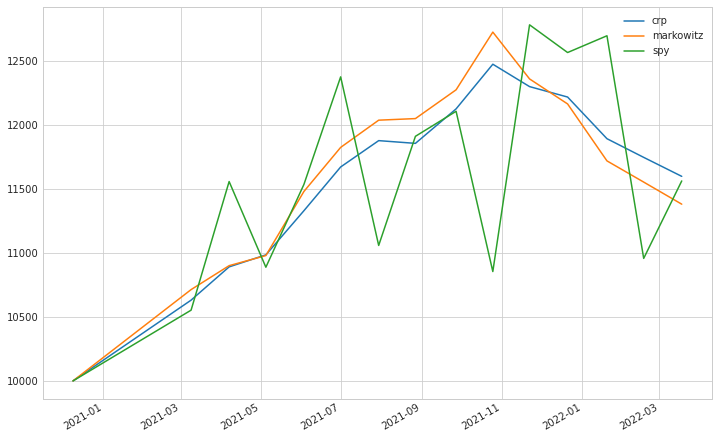

In [29]:
perf_df.plot(figsize=(12,8))